In [2]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from imblearn.over_sampling import RandomOverSampler
import lightgbm as lgb
import torch
import torch.nn as nn
from helper_functions_preprocessing import PreProcessor
import torch.nn.functional as F

import sklearn

import matplotlib.pyplot as plt
from tqdm import trange

## Bayesian Optimization
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

import itertools


# DEL Mini-Challenge 1
Es sollen Immobillienobjekte klassifiziert werden. Von der FHNW haben wir einen Datensatz erhalten (Siehe beiliegendes EDA-Notebook), in denen wir vorraussagen sollen, um was für ein Wohnobjekt es sich handelt; Ist es ein Zimmer? Wohnung? Haus? Diese Challenge hatten wir gelöst, aber ohne Deep Learning.
## Einführung
### Lösung der Mini-Challenge 1 für DEL
Wir benutzen ein Neutal-Network. Zur Erstellung wir das Deep-Learning Framework Pytorch benutzt.
### Ground Truth
Als Ground Truth bentzen wir das Modell, welches wir in der Challenge Immobillienrehcner benutzt haben. Mit diesem haben wir die Macro-F1 Score maximiert.


## Erstellung Modell Ground Truth

In [3]:
#read in data
csv_data = pd.read_csv('immo_dev_data.csv')
csv_data.head()

,Id,AreaLiving,AreaProperty,BuiltYear,FloorNumber,ForestDensityL,ForestDensityM,ForestDensityS,GroupNameDe,HouseObject,...,gde_private_apartments,gde_social_help_quota,gde_tax,gde_workers_sector1,gde_workers_sector2,gde_workers_sector3,gde_workers_total,location_has_street,location_is_complete,PurchasePrice
0,7135329,140.0,501.0,2016,NaN,0.418964,0.555985,0.730714,Haus,True,...,1358.0,3.660512,8.73,17.0,162.0,358.0,537.0,0,0,745000.0
1,7170979,143.0,277.0,2004,NaN,0.033259,0.074061,0.076468,Haus,True,...,3476.0,3.634717,6.13,0.0,2250.0,2787.0,5041.0,1,1,780000.0
2,7172246,160.0,712.0,1945,NaN,0.000000,0.000000,0.000000,Haus,True,...,2806.0,2.512344,9.79,167.0,1694.0,1138.0,2999.0,0,0,570000.0
3,7172252,351.0,496.0,2016,NaN,0.037575,0.000000,0.000000,Haus,True,...,131.0,1.734104,9.15,12.0,10.0,17.0,39.0,0,0,920000.0
4,7172733,400.0,1800.0,1975,NaN,0.095162,0.097193,0.153314,Haus,True,...,1181.0,1.056052,2.97,0.0,27.0,701.0,732.0,0,0,3950000.0


### Daten vorbereiten mit der Klasse PreProcessor
Wie in Eda gesehen, reicht, es, wenn wir nur die ersten zwei Ziffern von der Zip benutzen. Ebenfalls wurde folgende Sachen editiert mit den Daten:
- Onehot-Encoden: Kategorische Daten oder Strings werden Onehot-encoded. Dies bedeutet, dass ein Attribut in mehrere Attribute binär aufgeteilt wird und diese neuen Attribute sagen, ob dieser Eintrag ein String oder Kategorie enthält.
- Standardisieren auf die Z-Score: z=(x−μ)/σ​. (σ ist entweder die Standardabweichung oder das 75% Quantil subtrahiert vom 25% Quantil, falls der Robust-Scaler verwendet wird.)
- NANs auffüllen (entweder mit Mean oder Median oder mit einem bestimmten String).
- auf allen geskewten Werten eine Boxcox-Transformation durchführen, wobei dies bei unseren Test das Ergebniss nicht verbessert hat.
- 'StreetAndNr', 'LastUpdate', 'Locality', 'Id' werden gedropped; 'StreetAndNr' und 'LastUpdate' haben zuviele, einzigartige Werte und 'Locality' ist bereits im Zipcode vorhanden.
- Falls ein Attribut nur Werte zwischen 0 und 1 hat, wird ein neues Attribut kreiert, welches besagt, dass dieses Attribut 0 ist.
- Falls ein Attribut NANs hatte, wird ein neues Attribut erstellt, welches zeigt, wo ein Attribut NANs hatte.

Ebenfalls hat es 3 Reihen, welche alles NA sind. Diese kamen auch nicht im Kaggle-Datensatz vor, welches man hochladen konnte (teil der Challenge). Diese werden am Anfang also entfernt:


In [93]:
csv_data_fe = csv_data.copy()
## Drop der Reihen mit nur NAs:
csv_data_fe = csv_data_fe[csv_data_fe['TravelTimeMiv'].notna()].copy()
csv_data_fe = csv_data_fe[csv_data_fe['StateShort'].notna()].copy()
csv_data_fe = csv_data_fe[csv_data_fe['gde_area_settlement_percentage'].notna()].copy()

# Zip vereinfachen:
csv_data_fe['Zip'] = (csv_data_fe['Zip']/1000).astype('int8')
prepro = PreProcessor(csv_data_fe, y_var='GroupNameDe', method_to_encode='onehot_encode', cols_to_drop=['Id', 'LastUpdate', 'Locality', 'StreetAndNr', 'Longitude', 'Latitude', 'HouseObject','RealEstateTypeId'], numbers_to_encode=['Zip'], test_frac=0.2, remove_skew_by_boxcox = True)
prepro.preprocess()

### Metriken
Wir beginnen mit 2., den Metriken. Hierfür müssen wir uns als erstes einen Überblick über unsere Zielvariable verschaffen. Schauen wir einmal, wie viele verschiedene Objekttypen es gibt und wie viele Objekte es für jeden Typen gibt.

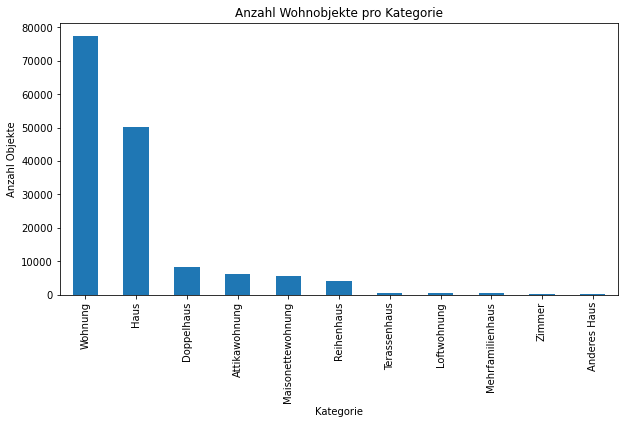

In [9]:
csv_data['GroupNameDe'].value_counts().plot(kind='bar', figsize=(10, 5), rot = 90)
plt.xlabel("Kategorie")
plt.ylabel("Anzahl Objekte")
plt.title("Anzahl Wohnobjekte pro Kategorie")
plt.show()

 Man kann im Plot sehr gut erkennen, dass es sich hier im eine ungleichmäsige Verteilung der Kategorien handelt. Da man einige Kategorien gar nicht erkennen kann, schauen wir noch die Zahlen an:

In [10]:
 csv_data['GroupNameDe'].value_counts()

Wohnung              77499
Haus                 50265
Doppelhaus            8397
Attikawohnung         6215
Maisonettewohnung     5517
Reihenhaus            4168
Terassenhaus           533
Loftwohnung            474
Mehrfamilienhaus       444
Zimmer                  89
Anderes Haus            26
Name: GroupNameDe, dtype: int64

Wir sehen also klar, dass die Daten extrem unbalanced sind. Dazu gibt es verschiedene Techniken. In der Challenge haben wir Oversampling benutzt.

### Oversampling
Oversampling bedeutet, dem Datensatz werden neue Objekte hinzugefügt um eine "Anzahl"-Balance zwischen allen Klassen herzustellen. Hierfür kann man bestehende Objekte zufällig auswählen und mehrmals hinzufügen bzw. kopieren oder komplett neue Objekte – basierend auf den bereits existierenden – erstellen. Dies funktioniert beispielsweise mit der SMOTE Methode. Hiermit werden wir uns auch beschäftigen.

In [11]:
ros = RandomOverSampler(random_state = 69)
X_random_, y_random_ = ros.fit_resample(prepro.X_train, prepro.y_train)
X_random = X_random_.sample(len(prepro.X_train), random_state = 69)
y_random = y_random_.iloc[X_random.index]

### Model trainieren
Wie oben gesagt, wird das NN verglichen mit einem Lightgbm-Mode, welches zu den "Boosted Tree"-Modellen gehört. Die besten Parameter haben wir schon gefunden gehabt mit Hilfe von Bayesian Optimization.

In [12]:
lgbc_best = lgb.LGBMClassifier(
        n_jobs = -1, seed = 42, learning_rate = 0.07517, max_depth = 340, n_estimators = 344,
        num_leaves = 90, reg_alpha = 1.136, reg_lambda = 4.348
)
lgbc_best.fit(X_random, y_random)

LGBMClassifier(learning_rate=0.07517, max_depth=340, n_estimators=344,
               num_leaves=90, reg_alpha=1.136, reg_lambda=4.348, seed=42)

In [13]:
lgbc_y_pred_best = lgbc_best.predict(prepro.X_test)

In [14]:
 print(sklearn.metrics.classification_report(prepro.y_test, lgbc_y_pred_best))

                   precision    recall  f1-score   support

     Anderes Haus       0.00      0.00      0.00         5
    Attikawohnung       0.31      0.67      0.43      1243
       Doppelhaus       0.40      0.59      0.47      1679
             Haus       0.92      0.80      0.86     10053
      Loftwohnung       0.42      0.54      0.47        95
Maisonettewohnung       0.29      0.57      0.38      1103
 Mehrfamilienhaus       0.30      0.55      0.38        89
       Reihenhaus       0.38      0.60      0.47       834
     Terassenhaus       0.47      0.60      0.52       107
          Wohnung       0.95      0.79      0.86     15500
           Zimmer       0.13      0.11      0.12        18

         accuracy                           0.76     30726
        macro avg       0.42      0.53      0.45     30726
     weighted avg       0.84      0.76      0.79     30726



In [15]:
prepro.y_test

48209     Anderes Haus
53271     Anderes Haus
3683      Anderes Haus
59551     Anderes Haus
49477     Anderes Haus
              ...     
111519          Zimmer
119965          Zimmer
122710          Zimmer
125162          Zimmer
121313          Zimmer
Name: GroupNameDe, Length: 30726, dtype: object

### Confusion Matrix LightGBM

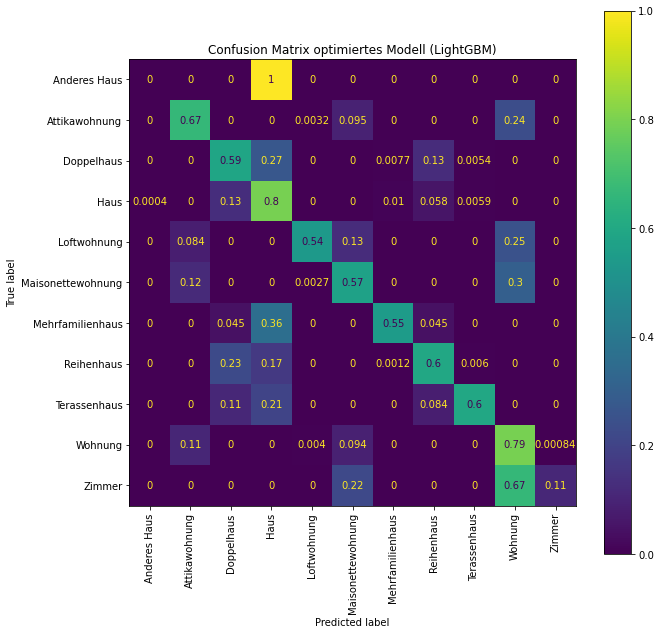

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))
sklearn.metrics.plot_confusion_matrix(lgbc_best, prepro.X_test, prepro.y_test, normalize = 'true', xticks_rotation='vertical', ax = ax)
plt.title('Confusion Matrix optimiertes Modell (LightGBM)')
plt.show()

## Neural Network-Model
LightGBM macht automatisch aus String Zahlen, welche vom Model verstanden werden können. Pytorch macht das nicht. Zur optimierung des Modelles benutzen wir hier ebenfalls Bayesian Optimization.

In [18]:
enc = sklearn.preprocessing.OneHotEncoder(handle_unknown='ignore', sparse=False)
enc.fit(prepro.y_train.values.reshape(-1,1))

y_train_ohc = enc.transform(prepro.y_train.values.reshape(-1,1))
y_test_ohc = enc.transform(prepro.y_test.values.reshape(-1,1))

In [19]:
y_test_ohc.shape

(30726, 11)

In [20]:
enc.categories_

[array(['Anderes Haus', 'Attikawohnung', 'Doppelhaus', 'Haus',
        'Loftwohnung', 'Maisonettewohnung', 'Mehrfamilienhaus',
        'Reihenhaus', 'Terassenhaus', 'Wohnung', 'Zimmer'], dtype=object)]

In [21]:
if torch.cuda.is_available():
  device = torch.device("cuda:10")
  print("Cuda Device Available")
  print("Name of the Cuda Device: ", torch.cuda.get_device_name())
  print("GPU Computational Capablity: ", torch.cuda.get_device_capability())
  use_cuda = True

Cuda Device Available
Name of the Cuda Device:  GeForce RTX 3060 Ti
GPU Computational Capablity:  (8, 6)


In [114]:
prepro.X_train.columns

Index(['AreaLiving', 'AreaProperty', 'BuiltYear', 'FloorNumber',
       'ForestDensityL', 'ForestDensityM', 'ForestDensityS',
       'NoisePollutionRailwayL', 'NoisePollutionRailwayM',
       'NoisePollutionRailwayS',
       ...
       'StateShort_ZH', 'Zip_1_', 'Zip_2_', 'Zip_3_', 'Zip_4_', 'Zip_5_',
       'Zip_6_', 'Zip_7_', 'Zip_8_', 'Zip_9_'],
      dtype='object', length=134)

In [115]:
# Falls wir etwas auf der GPU laufen möchten, müssen wir Pytorch explizit sagen, das es das Model und die benötigten Daten auf die GPU schreiben soll:
if torch.cuda.is_available():
    ## To tensors and put them on the gpu:
    y_ohc_train_t = torch.tensor(y_train_ohc, dtype=torch.uint8).cuda()
    X_train_t = torch.tensor(prepro.X_train.values.astype('float32'), dtype=torch.float32).cuda()
    y_ohc_test_t = torch.tensor(y_test_ohc, dtype=torch.uint8).cuda()
    X_test_t = torch.tensor(prepro.X_test.values.astype('float32'), dtype=torch.float32).cuda()
else: 
    NotImplementedError

In [116]:
def calc_nr_neuros(X, output_neurons, alpha=2):
    """
    This function calculates with pi * thumb how many neuros there should be in a hidden layer.
    https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw
    :param X: X which will be given to the NN.
    :param alpha: parameter to change the number of neurons in the hidden layer
    :return: int
    """
    sample_size, input_dim = X.shape
    return int(sample_size / (alpha * (input_dim + output_neurons)))


def one_hot_ce_loss(outputs, target):
    """
    CrossEntropyLoss accepts only label-encoded predictions. Thus, OHC target changed to label-encoding here.
    See: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html"""
    criterion = nn.CrossEntropyLoss()
    _, label = torch.max(target, dim=1)
    return criterion(outputs, label)

In [128]:
# Parameter for the model
input_dim = X_train_t.shape[1]
output_dim = y_test_ohc.shape[1]
nr_of_neuros = calc_nr_neuros(X_train_t, output_dim, 2)


def create_model(nr_layers, hdim, dropout):
    class Model(nn.Module):

        def __init__(self, input_dim, output_dim, nr_layers, hdim, dropout):
            super().__init__()

            self.layers = nn.ModuleList()
            current_dim = input_dim

            for _ in range(nr_layers):
                self.layers.append(nn.Linear(current_dim, hdim))
                #self.layers.append(nn.BatchNorm1d(hdim))
                #self.layers.append(nn.Dropout(dropout))
                current_dim = hdim
            self.layers.append(nn.Linear(current_dim, output_dim))

            self.iniziate_weights()

        def forward(self,x):
            for layer in self.layers[:-1]:
        
                if isinstance(layer, torch.nn.modules.linear.Linear):
                    x = F.leaky_relu(layer(x))
                else:
                    x = layer(x)

            x = F.softmax(self.layers[-1](x), dim=1)
            return x

        def iniziate_weights(self):
            for m in self.layers:
                if isinstance(m, torch.nn.modules.linear.Linear):
                    nn.init.kaiming_uniform_(m.weight)
                    nn.init.constant_(m.bias, 0.01)

                elif isinstance(m, nn.BatchNorm2d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)

    return Model(input_dim, output_dim, nr_layers, hdim, dropout)


# Create Model, define Paramter, define loss-function 
model = create_model(3, nr_of_neuros, 0.05)
optimizer = torch.optim.Adam(params = model.parameters(), lr=0.000001)

# Define weights:
weights = torch.tensor(1 / (prepro.y_train.value_counts() / prepro.y_train.value_counts().sum()).astype('float32')).cuda()

# Falls wir etwas auf der GPU laufen möchten, müssen wir Pytorch explizit sagen, das es das Model und die benötigten Daten auf die GPU schreiben soll:
if torch.cuda.is_available():
    device = torch.device("cuda" if use_cuda else "cpu")
    model.to(device)

In [129]:
model

Model(
  (layers): ModuleList(
    (0): Linear(in_features=134, out_features=423, bias=True)
    (1): Linear(in_features=423, out_features=423, bias=True)
    (2): Linear(in_features=423, out_features=423, bias=True)
    (3): Linear(in_features=423, out_features=11, bias=True)
  )
)

In [130]:
prepro.y_train.value_counts()

Wohnung              61998
Haus                 40212
Doppelhaus            6716
Attikawohnung         4972
Maisonettewohnung     4414
Reihenhaus            3334
Terassenhaus           426
Loftwohnung            379
Mehrfamilienhaus       355
Zimmer                  71
Anderes Haus            21
Name: GroupNameDe, dtype: int64

In [167]:
EPOCHS = 500
BATCH_SIZE = 2**5
warm_up = 200
max_loop_no_improve = 50

aggregated_losses = []
test_losses = []


# Setup:
samples, features = X_train_t.shape
nr_batches_per_epoch = int(m/BATCH_SIZE)
epoch_loop = trange(EPOCHS, position=0, leave=True)
batch_loop = range(nr_batches_per_epoch)# position=1, leave=True)

for i in epoch_loop:

    current_loss = torch.tensor(0, dtype=torch.float32).cuda()
    for j in batch_loop:
        rand_idx = np.random.randint(0, samples - BATCH_SIZE)
        # Get random batch:
        y = y_ohc_train_t[rand_idx:rand_idx+BATCH_SIZE,:]
        x = X_train_t[rand_idx:rand_idx+BATCH_SIZE,:]

        # Preidct, calculate loss and update weights
        y_pred = model(x)
        single_loss = one_hot_ce_loss(y_pred, y)

        # Apply weights to loss:
        single_loss = (single_loss * weights).mean()

        optimizer.zero_grad()
        single_loss.backward()
        optimizer.step()
        current_loss += single_loss.float()
    
    current_loss = current_loss / nr_batches_per_epoch

    with torch.no_grad():
        aggregated_losses.append(current_loss)
        epoch_loop.set_description(f'epoch: {i:3} loss: {current_loss.cpu().numpy():10.8f}')

 

    if i > warm_up and max(aggregated_losses[-max_loop_no_improve:]) < test_losses[-1]:
        print("Early stopping!")
        break
 
print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:  72 loss: 1601.75976562:  15%|█▍        | 73/500 [15:19<1:29:37, 12.59s/it]


KeyboardInterrupt: 

In [169]:
aggregated_losses

[tensor(1604.3922, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(1604.0713, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(1605.3636, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(1607.8820, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(1605.7738, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(1600.9473, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(1597.5004, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(1604.0444, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(1595.8864, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(1598.8002, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(1605.6454, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(1608.0669, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(1604.5710, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(1600.4242, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(1601.2347, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(1612.6436, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(1599.4662, devic

In [162]:
y_pred = model(X_test_t)

Normalized confusion matrix


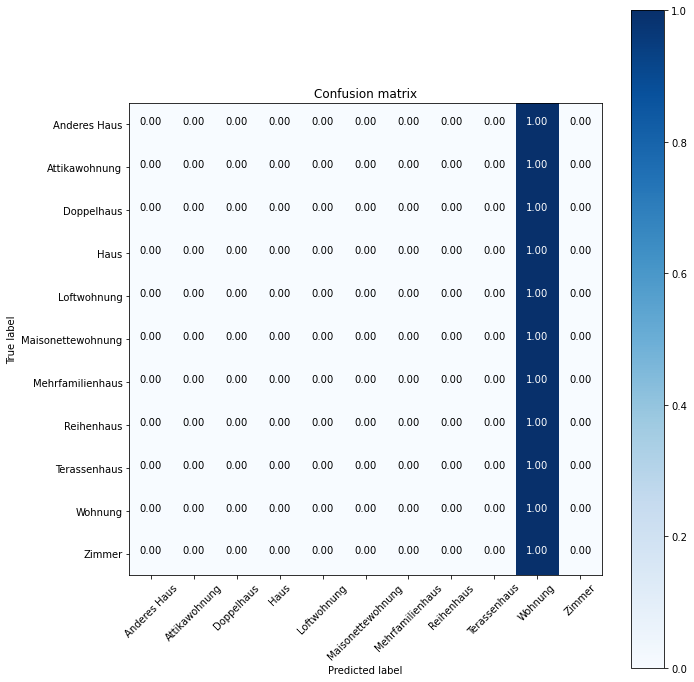

In [163]:
### Evaluation:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = sklearn.metrics.confusion_matrix(y_ohc_test_t.cpu().argmax(axis = 1), y_pred.cpu().argmax(axis = 1))
cm_n = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, enc.categories_[0], normalize=True)

In [61]:
enc.categories_

[array(['Anderes Haus', 'Attikawohnung', 'Doppelhaus', 'Haus',
        'Loftwohnung', 'Maisonettewohnung', 'Mehrfamilienhaus',
        'Reihenhaus', 'Terassenhaus', 'Wohnung', 'Zimmer'], dtype=object)]